# Working with Charts, Graphs, and Slide Decks
Claude is highly capable of working with charts, graphs, and broader slide decks. Depending on your use case, there are a number of tips and tricks that you may want to take advantage of. This recipe will show you common patterns for using Claude with these materials.

## Charts and Graphs
For the most part, using claude with charts and graphs is simple. Let's walk through how to ingest them and pass them to Claude, as well as some common tips to improve your results.

### Ingestion and calling the Claude API
The best way to pass Claude charts and graphs is to take advantage of its vision capabilities. That is, give Claude an image of the chart or graph, along with a text question about it. While all versions of Claude can accept images, Sonnet and Opus are our recommended models for data-heavy image tasks. Let's get started using Sonnet.

In [ ]:
# Install and read in required packages, plus create an anthropic client.
%pip install anthropic IPython pdf2image

In [9]:
import base64
from anthropic import Anthropic
from IPython.display import Image
client = Anthropic()
MODEL_NAME = "claude-3-opus-20240229"

In [7]:
# Make a useful helper function.
def get_completion(messages):
    response = client.messages.create(
        model=MODEL_NAME,
        max_tokens=2048,
        temperature=0,
        messages=messages
    )
    return response.content[0].text

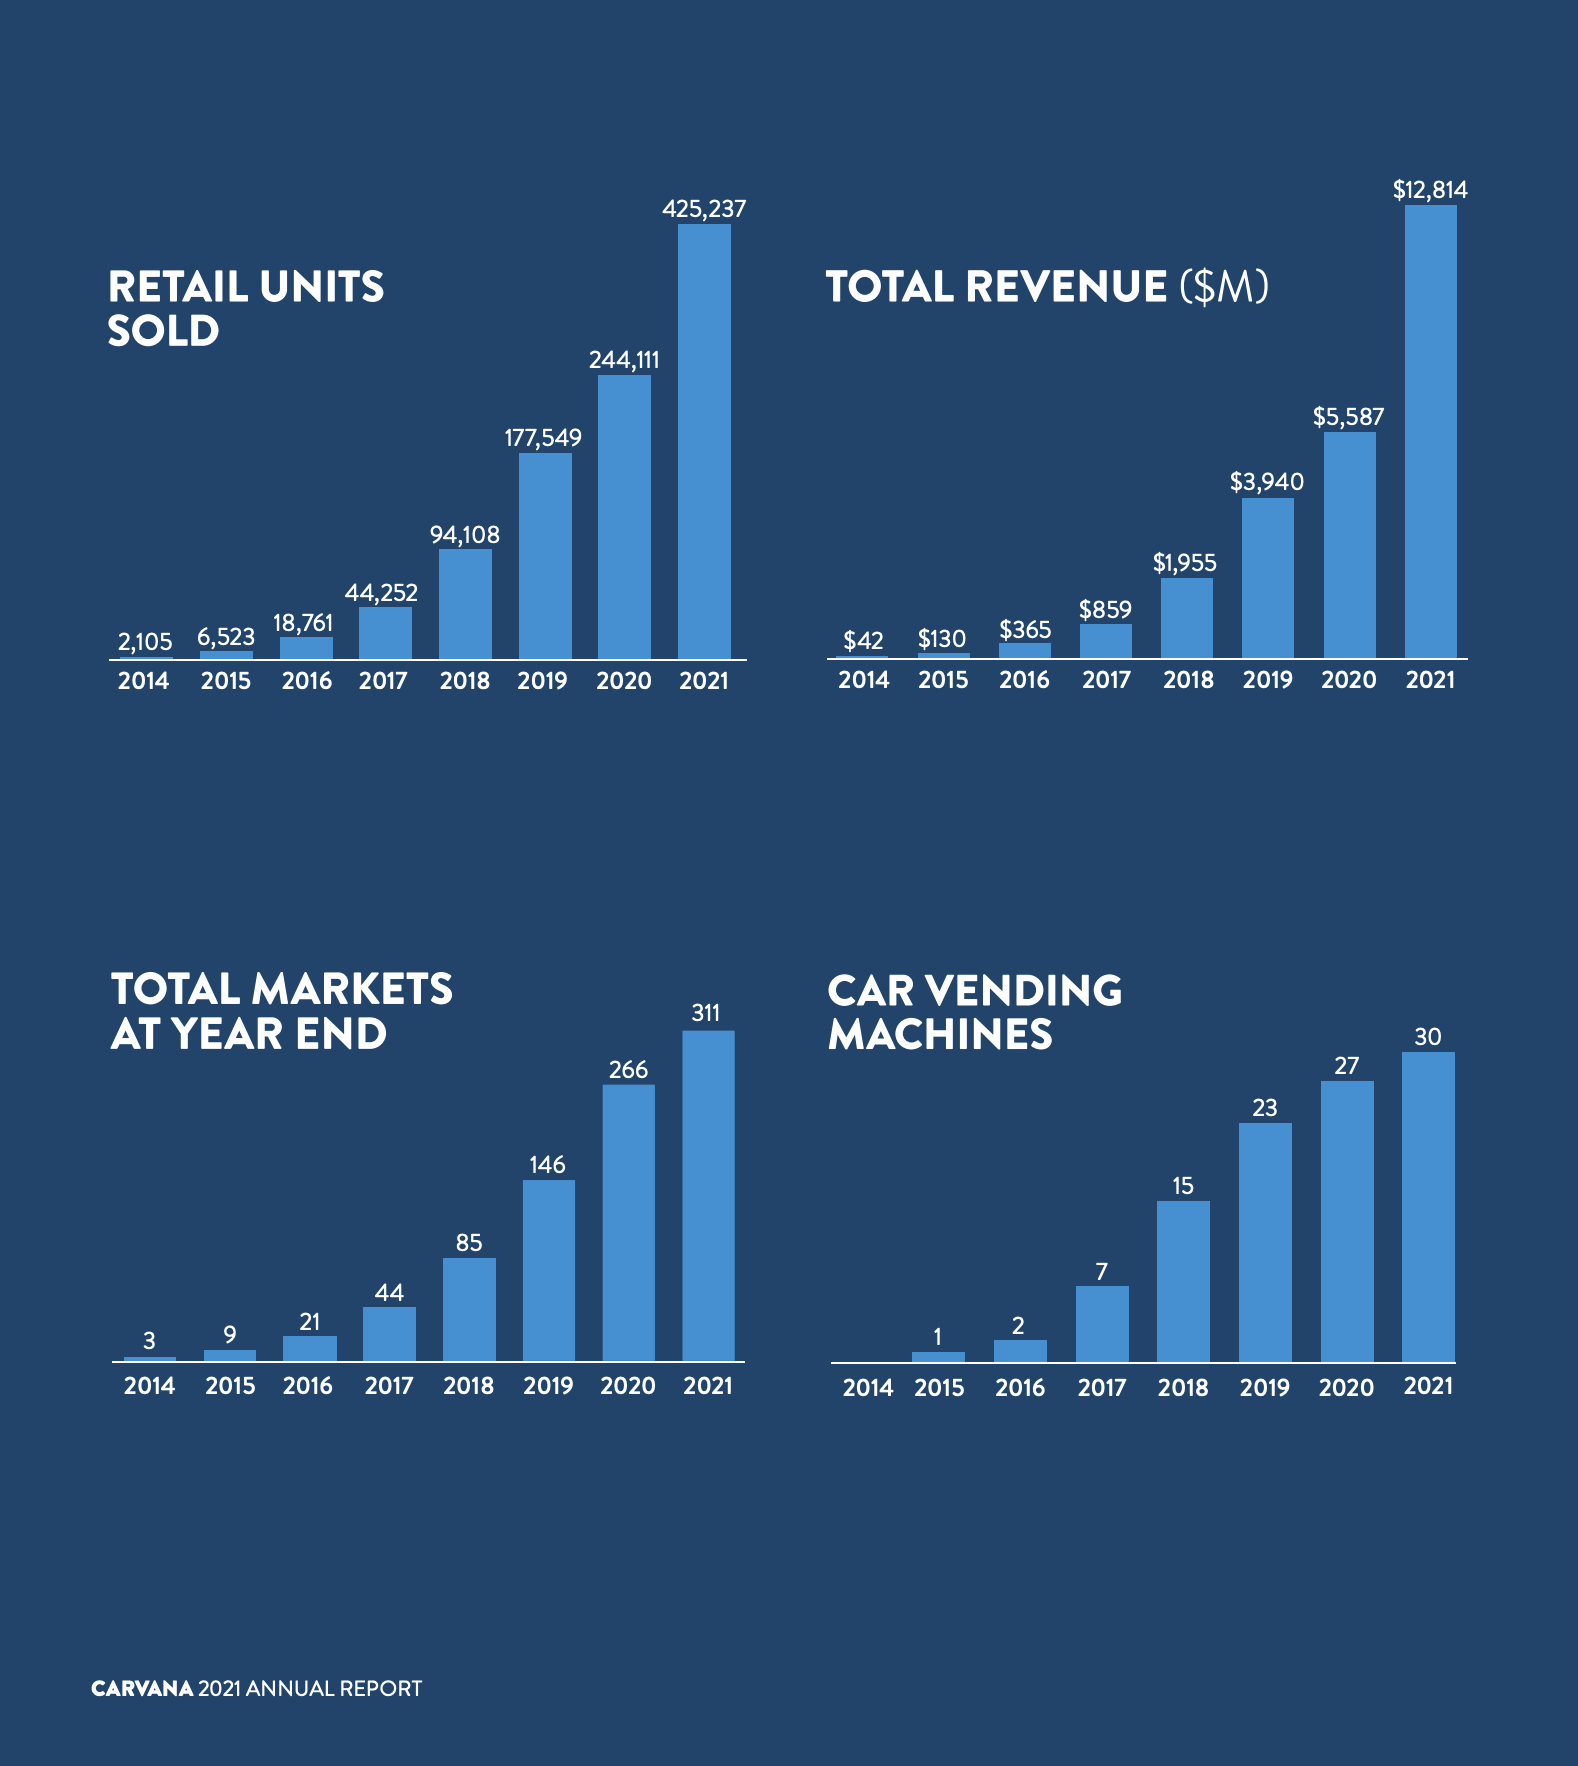

In [6]:
# To start, we'll need an image. We will be using the .png image located at cvna_2021_annual_report_image.png.
# Start by reading in the image and encoding it as base64.
with open("../images/reading_charts_graphs/cvna_2021_annual_report_image.png", "rb") as image_file:
    binary_data = image_file.read()
    base_64_encoded_data = base64.b64encode(binary_data)
    base64_string = base_64_encoded_data.decode('utf-8')

# Let's also see the image for ourself
Image(filename='../images/reading_charts_graphs/cvna_2021_annual_report_image.png') 

Let's see how we can pass this image to the model alongside a simple question.

In [8]:
messages = [
    {
        "role": 'user',
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": base64_string}},
            {"type": "text", "text": "What's in this image? Answer in a single sentence."}
        ]
    }
]

print(get_completion(messages))

The image shows various financial metrics and growth trends from Carvana's 2021 annual report, including retail units sold, total revenue, total markets, and car vending machines over the years 2014 to 2021.


That's pretty good! Now let's ask it some more useful questions.

In [10]:
questions = [
    "What was CVNA revenue in 2020?",
    "How many additional markets has Carvana added since 2014?",
    "What was 2016 revenue per retail unit sold?"
]

for index, question in enumerate(questions):
    messages = [
        {
            
            "role": 'user',
            "content": [
                {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": base64_string}},
                {"type": "text", "text": question}
            ]
        }
    ]

    print(f"\n----------Question {index+1}----------")
    print(get_completion(messages))


----------Question 1----------
According to the "Total Revenue ($M)" chart in Carvana's 2021 Annual Report, Carvana's total revenue in 2020 was $5,587 million.

----------Question 2----------
According to the "Total Markets at Year End" chart, Carvana had 3 markets in 2014 and expanded to 311 markets by 2021. Therefore, Carvana has added 308 additional markets since 2014.

----------Question 3----------
To calculate the revenue per retail unit sold in 2016, I'll divide the total revenue by the retail units sold for that year.

Total revenue in 2016: $1,955 million
Retail units sold in 2016: 18,761

Revenue per retail unit = $1,955 million / 18,761 units
            = $1,955,000,000 / 18,761
            = $104,217 per unit

So in 2016, the revenue per retail unit sold was $104,217.


As you can see, Claude is capable of answering fairly detailed questions about charts and graphs. However, there are some tips and tricks that will help you get the most out of it.
- Sometimes Claude's arithmetic capabilities get in the way. You'll notice that if you sample the third question above it will occasionally output an incorrect final answer because it messes up the arithmetic. Consider providing Claude with a calculator tool to ensure it doesn't make these types of mistakes.
- With super complicated charts and graphs, we can ask Claude to "First describe every data point you see in the image" as a way to elicit similar improvements to what we seen in traditional Chain of Thought.
- Claude occasionally struggles with charts that depend on lots of colors to convey information, such as grouped bar charts with many groups. Asking Claude to first identify the colors in your graph using HEX codes can boost its accuracy.

## Slide Decks
Now that we know Claude is a charts and graphs wizard, it is only logical that we extend it to the true home of charts and graphs - slide decks!

Slides represent a critical source of information for many domains, including financial services. While you *can* use packages like PyPDF to extract text from slide decks, their chart/graph heavy nature often makes this a poor choice as models will struggle to access the information they actually need. Vision can be a great replacement as a result. In this section we will go over how to use vision Claude to review slide decks, and how to deal with some common pitfalls of this approach.

The best way to get a typical slide deck into claude is to download it as a PDF and then convert each pdf page to an image. Here's how you can accomplish this.

In [ ]:
%pip install PyMuPDF

In [12]:
from PIL import Image
import io
import fitz

# Define the function to convert a pdf slide deck to a list of images. Note that we need to ensure we resize images to keep them within Claude's size limits.
def pdf_to_base64_pngs(pdf_path, quality=75, max_size=(1024, 1024)):
    # Open the PDF file
    doc = fitz.open(pdf_path)

    # Iterate through each page of the PDF
    for page_num in range(doc.page_count):
        # Load the page
        page = doc.load_page(page_num)

        # Render the page as a PNG image
        pix = page.get_pixmap(matrix=fitz.Matrix(300/72, 300/72))

        # Save the PNG image
        output_path = f"../images/reading_charts_graphs/slides/page_{page_num+1}.png"
        pix.save(output_path)

    # Convert the PNG images to base64 encoded strings
    images = [Image.open(f"../images/reading_charts_graphs/slides/page_{page_num+1}.png") for page_num in range(doc.page_count)]
    # Close the PDF document
    doc.close()

    base64_encoded_pngs = []

    for image in images:
        # Resize the image if it exceeds the maximum size
        if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
            image.thumbnail(max_size, Image.Resampling.LANCZOS)
        image_data = io.BytesIO()
        image.save(image_data, format='PNG', optimize=True, quality=quality)
        image_data.seek(0)
        base64_encoded = base64.b64encode(image_data.getvalue()).decode('utf-8')
        base64_encoded_pngs.append(base64_encoded)

    return base64_encoded_pngs

# Call the function on our q4 2023 Twilio Earnings presentation
pdf_path = '../images/reading_charts_graphs/twilio_q4_2023.pdf' # This is the path to our slide deck.
encoded_pngs = pdf_to_base64_pngs(pdf_path)

In [13]:
# Now let's pass the first 20 of these images (in order) to Claude at once and ask it a question about the deck. Why 20? Currently, the Anthropic API only allows you to pass in a maximum of 20 images. While this number will likely increase over time, we have some helpful tips for how to manage it later in this recipe.
content = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}} for encoded_png in encoded_pngs[:20]]
question = "What was Twilio y/y revenue growth for fiscal year 2023?"
content.append({"type": "text", "text": question})
messages = [
    {
        "role": 'user',
        "content": content
    }
]

print(get_completion(messages))

According to the "Total Company Results Highlights" table, Twilio's Y/Y Revenue Growth for fiscal year 2023 was 9%.


This approach is a great way to get started, and for some use cases offers the best performance. However, there are some limitations.
- You can only include up to 20 images (we intend to increase this limit over time)
- If you are using slide content as part of RAG, introducing images into your embeddings can cause problems

Luckily, we can take advantage of Claude's vision capabilities to get a much higher quality representation of the slide deck **in text form** than normal pdf transciption allows.

We find the best way to do this is to ask Claude to sequentially narrate the deck from start to finish, passing it the current slide and its prior narration. Let's see how.

In [15]:
# Define two functions that allow us to craft prompts for narrating our slide deck. We would adjut these prompts based on the nature of the deck, but keep the structure largely the same.
def build_previous_slides_prompt(previous_slide_narratives):
    prompt = '\n'.join([f"<slide_narration id={index+1}>\n{narrative}\n</slide_narration>" for index, narrative in enumerate(previous_slide_narratives)])
    return prompt

def build_slides_narration_prompt(previous_slide_narratives):
    if len(previous_slide_narratives) == 0:
        prompt = """You are the Twilio CFO, narrating your Q4 2023 earnings presentation.

You are currently on slide 1, shown in the image.
Please narrate this page from Twilio's Q4 2023 Earnings Presentation as if you were the presenter. Do not talk about any things, especially acronyms, if you are not exactly sure you know what they mean. Do not discuss anything not explicitly seen on this slide as there are more slides to narrate later that will likely cover that material.
Do not leave any details un-narrated as some of your viewers are vision-impaired, so if you don't narrate every number they won't know the number.

Put your narration in <narration> tags."""

    else:
        prompt = f"""You are the Twilio CFO, narrating your Q4 2023 earnings presentation. So far, here is your narration from previous slides:
<previous_slide_narrations>
{build_previous_slides_prompt(previous_slide_narratives)}
</previous_slide_narrations>

You are currently on slide {len(previous_slide_narratives)+1}, shown in the image.
Please narrate this page from Twilio's Q4 2023 Earnings Presentation as if you were the presenter, accounting for what you have already said on previous slides. Do not talk about any things, especially acronyms, if you are not exactly sure you know what they mean. Do not discuss anything not explicitly seen on this slide as there are more slides to narrate later that will likely cover that material.
Do not leave any details un-narrated as some of your viewers are vision-impaired, so if you don't narrate every number they won't know the number.

Use excruciating detail.

Put your narration in <narration> tags."""
    
    return prompt

In [14]:
# Now we use our functions to narrate the entire deck. Note that this may take a few minutes to run (often up to 10).
import re
from tqdm import tqdm
previous_slide_narratives = []
for i, encoded_png in tqdm(enumerate(encoded_pngs)):
    messages = [
        {
            "role": 'user',
            "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}},
            {"type": "text", "text": build_slides_narration_prompt(previous_slide_narratives)}
        ]
        }
    ]
    completion = get_completion(messages)
    
    pattern = r"<narration>(.*?)</narration>"
    match = re.search(pattern, completion.strip(), re.DOTALL)
    if match:
        narration = match.group(1)
    else:
        raise ValueError("No narration available.")
    
    previous_slide_narratives.append(narration)
    # If you want to see the narration we produced, uncomment the below line
    # print(narration)

slide_narration = build_previous_slides_prompt(previous_slide_narratives)

27it [06:15, 13.92s/it]


Now that we have a text-based narration (it's far from perfect but it's pretty good), we have the ability to use this deck with any text-only workflow. Including vector search!

As a final sanity check, let's ask a few questions of our narration-only setup!

In [15]:
questions = [
    "What percentage of q4 total revenue was the Segment business line?",
    "Has the rate of growth of quarterly revenue been increasing or decreasing? Give just an answer.",
    "What was acquisition revenue for the year ended december 31, 2023 (including negative revenues)?"
]

for index, question in enumerate(questions):
    prompt = f"""You are an expert financial analyst analyzing a transcript of Twilio's earnings call.
Here is the transcript:
<transcript>
{slide_narration}
</transcript>

Please answer the following question:
<question>
{question}
</question>"""
    messages = [
        {
            
            "role": 'user',
            "content": [
                {"type": "text", "text": prompt}
            ]
        }
    ]

    print(f"\n----------Question {index+1}----------")
    print(get_completion(messages))


----------Question 1----------
According to the "Segment Results Highlights" slide, Twilio's Segment business line revenue for Q4 2023 was $75 million. And from the "Total Company Results Highlights" slide, Twilio's total revenue for Q4 2023 was $1,076 million.

To calculate the percentage of Q4 total revenue that the Segment business line contributed:

Segment revenue ($75 million) / Total revenue ($1,076 million) = 0.0697 or 6.97%

So the Segment business line accounted for approximately 6.97% of Twilio's total revenue in Q4 2023.

----------Question 2----------
The rate of growth of quarterly revenue has been decreasing.

----------Question 3----------
According to the "Non-GAAP Financial Measures Reconciliation" slide for organic revenue (slide 23), the acquisition revenue excluded from GAAP revenue to calculate organic revenue for the year ended December 31, 2023 was -$2,088,000.


Looks good! With these techniques at your side, you are ready to start applying models to chart and graph heavy content like slide decks.